# Dar Es Salaam built environment

This notebook builds a dataset for Dar Es Salaam (Tanzania) describing the built environment. Two main aspects are considered: the street network and buildings. To capture those, the following variables are calculated at for the H3 hexagonal grid system, zoom level 8:

- Building density: number of buildings per hexagon
- Building coverage: proportion of the hexagon covered by buildings
- Street length: total length of streets within the hexagon
- Street linearity: a measure of how regular the street network is

In [1]:
import pandas
import geopandas
import pyrosm
import contextily
import h3
import matplotlib.pyplot as plt
from momepy import Linearity
from shapely.geometry import box, Polygon

## Raw data extraction

The original dataset was extracted on Sep. 17th 2020 through the [BBBike Extract Service](https://extract.bbbike.org/). The query specs included:

```
 Name: Dar Es Salaam Centre
 Coordinates: 39.199,-6.86 x 39.409,-6.73
 Script URL: https://extract.bbbike.org?sw_lng=39.199&sw_lat=-6.86&ne_lng=39.409&ne_lat=-6.73&format=osm.pbf&city=Dar+Es+Salaam+Centre&lang=en
 Square kilometre: 335
 Granularity: 100 (1.1 cm)
 Format: osm.pbf
 File size: 14.2 MB
 SHA256 checksum: e34efe1033e0641361b0b2977f2897c09fabb2a43e50983b97fccbc71036925c
 MD5 checksum: 00214e925fdcecb207622b8d27ad523b
 Last planet.osm database update: Fri Sep 11 09:54:19 2020 UTC
 License: OpenStreetMap License
```

The area covered by that extent can be seen below:

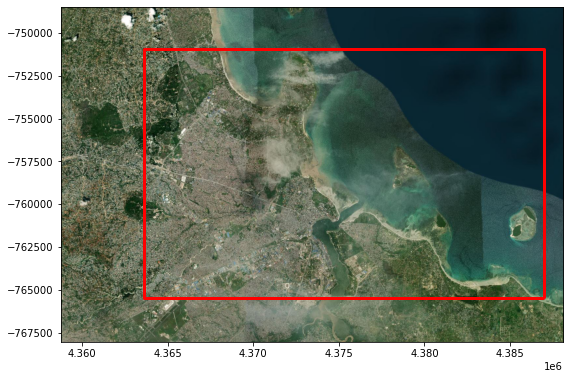

In [2]:
e, s, w, n = 39.199,-6.86, 39.409,-6.73
bbox = box(e, s, w, n)
img, extent = contextily.bounds2img(e, 
                                    s, 
                                    w, 
                                    n, 
                                    ll=True,
                                    source=contextily.providers.Esri.WorldImagery
                                   )
f, ax = plt.subplots(figsize=(9, 9))
ax.imshow(img, extent=extent)
geopandas.GeoSeries([bbox], crs="EPSG:4326")\
         .to_crs(epsg=3857)\
         .plot(ax=ax, 
               linewidth=3,
               edgecolor="red", 
               facecolor="none"
              )
plt.show()

This is downloaded into a `.osm.pbf` that is placed on the same folder as this notebook for processing. 

## Extract features from OSM

Let's set up the reader:

In [3]:
osm = pyrosm.OSM("planet_39.199,-6.86_39.409,-6.73.osm.pbf")

### Streets

In [4]:
%time streets = osm.get_network()

/opt/conda/lib/python3.7/site-packages/pyrosm/networks.py:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  osm_keys="highway",


CPU times: user 21.7 s, sys: 1.68 s, total: 23.4 s
Wall time: 23.3 s


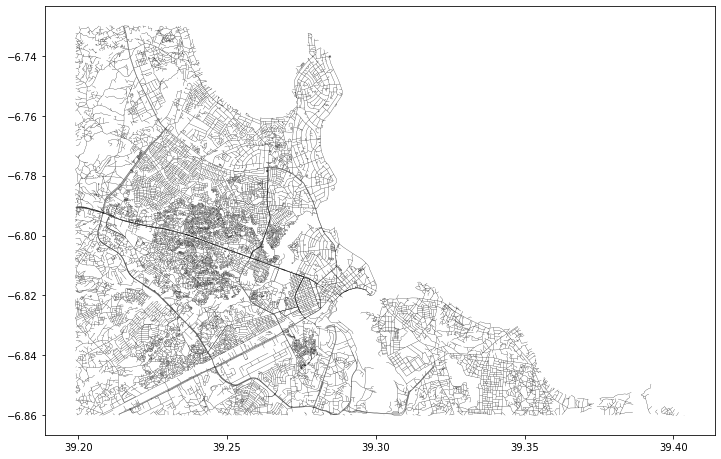

In [5]:
ax = streets.plot(color="k", linewidth=0.25, figsize=(12, 12));

### Buildings

In [6]:
%time buildings = osm.get_buildings()

/opt/conda/lib/python3.7/site-packages/pyrosm/buildings.py:27: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  osm_keys=None


CPU times: user 1min 10s, sys: 1.45 s, total: 1min 12s
Wall time: 1min 12s


CPU times: user 4min 41s, sys: 3.61 s, total: 4min 44s
Wall time: 4min 43s


<AxesSubplot:>

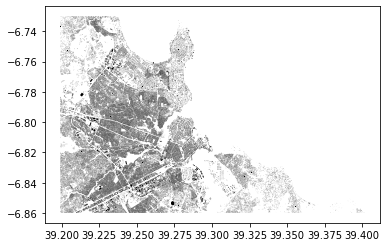

In [7]:
%time buildings.plot(edgecolor="none", facecolor="k");

## Generate `h3` geography

This parallels the H3 extraction on the [GDS book](https://geographicdata.science/book/data/h3_grid/build_sd_h3_grid.html). Let's start by drawing the limits for which we will obtains hexagons. For ease of computation, we do this with the convex hull of the boundaries provided by OSM:

/opt/conda/lib/python3.7/site-packages/pyrosm/boundary.py:34: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  osm_keys=None


<AxesSubplot:>

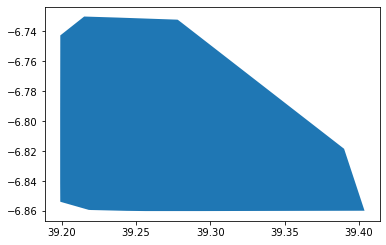

In [8]:
boundaries = osm.get_boundaries()
limits = geopandas.GeoSeries([boundaries.unary_union.convex_hull], 
                             crs=boundaries.crs
                            )
limits.plot()

Once we have the limits, we pull out the hexagon IDs for that region:

In [9]:
zoom = 8
hexs = h3.polyfill(limits.geometry[0].__geo_interface__, 
                   9, 
                   geo_json_conformant = True
                  )
print(f"Zoom: {zoom} | No. of hexs: {len(hexs)}")

Zoom: 8 | No. of hexs: 2046


With the IDs, we can generate the geometries:

In [10]:
polygonise = lambda hex_id: Polygon(
                                h3.h3_to_geo_boundary(
                                    hex_id, geo_json=True)
                                    )

%time all_polys = geopandas.GeoSeries(list(map(polygonise, hexs)), \
                                      index=hexs, \
                                      crs="EPSG:4326" \
                                     )

CPU times: user 226 ms, sys: 48.4 ms, total: 275 ms
Wall time: 217 ms


<AxesSubplot:>

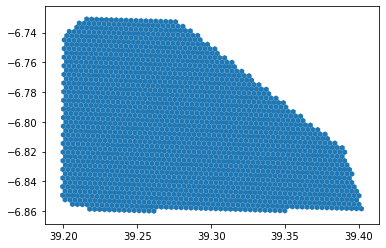

In [11]:
all_polys.plot()

## Aggregate features to `h3`

With the target geography at hand, we can start creating attributes for each area.

### Building density

In [12]:
%%time
b2h = geopandas.sjoin(geopandas.GeoDataFrame({"geometry": buildings.centroid,
                                              "id": buildings["id"]
                                             }, crs=buildings.crs),
                      geopandas.GeoDataFrame({"geometry": all_polys.geometry,
                                              "hid": all_polys.index
                                             }, crs="EPSG:4326")
                     )

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  """Entry point for launching an IPython kernel.


CPU times: user 4.46 s, sys: 248 ms, total: 4.7 s
Wall time: 4.69 s


In [13]:
building_count = b2h.groupby("hid").size()

<AxesSubplot:>

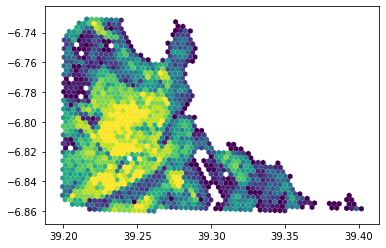

In [14]:
geopandas.GeoDataFrame({"geometry": all_polys,
                        "count": building_count
                       }).plot(column="count", scheme="quantiles", k=12)

### Building coverage

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  """Entry point for launching an IPython kernel.


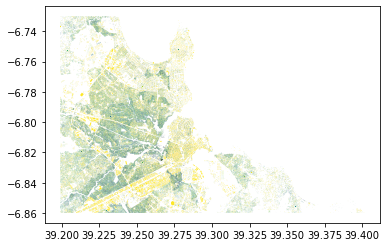

In [15]:
buildings.assign(area=buildings.area)\
         .plot(column="area", 
               scheme="quantiles", 
               k=9, 
               edgecolor="none"
              );

There are several types of geometries:

In [16]:
buildings.geometry.type.unique()

array(['Polygon', 'LineString', 'MultiPolygon'], dtype=object)

However, the vast majority is one type:

In [17]:
buildings.groupby(buildings.geometry.type).size()

LineString         229
MultiPolygon         3
Polygon         338539
dtype: int64

Given the proportions, we discard everything that is not a `Polygon`:

In [18]:
%%time
type_filter = buildings.geometry.type == "Polygon"
cookie_cutter = geopandas.overlay(buildings[type_filter][["id", "geometry"]],
                                  geopandas.GeoDataFrame({"geometry": all_polys.geometry,
                                                          "hid": all_polys.index
                                                         }, crs="EPSG:4326"),
                                  how="intersection"
                                 )

CPU times: user 1min 21s, sys: 180 ms, total: 1min 21s
Wall time: 1min 21s


In [19]:
building_coverage = cookie_cutter.assign(area=cookie_cutter.area)\
                                 .groupby("hid")\
                                 .sum()
building_coverage = building_coverage["area"] * 100 / all_polys.area

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  after removing the cwd from sys.path.


### Street length and linearity

In [20]:
%%time
streets = streets.explode()
inp, res = streets.centroid.sindex.query_bulk(all_polys.geometry, predicate='intersects')
lengths = pandas.Series(None, index=all_polys.index)
linearities = pandas.Series(None, index=all_polys.index)
for poly in range(len(all_polys)):
    subset = streets.iloc[res[inp==poly]]
    # Length
    intersection_length = subset.length
    lengths[all_polys.index[poly]] = intersection_length.sum()
    # Weighted Linearity
    try:
        w = intersection_length / intersection_length.sum()
        linearity = (Linearity(subset).series * w).sum()
    except:
        linearity = None
    linearities[all_polys.index[poly]] = linearity

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeri

CPU times: user 5min 6s, sys: 8.93 s, total: 5min 15s
Wall time: 5min 10s


/opt/conda/lib/python3.7/site-packages/momepy/shape.py:1174: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  self.series = euclidean / gdf.geometry.length


In [21]:
street_features = geopandas.GeoDataFrame({"id": all_polys.index,
                                          "length": lengths,
                                          "linearity": linearities,
                                          "geometry": all_polys
                                         })

/opt/conda/lib/python3.7/site-packages/mapclassify/classifiers.py:236: UserWarning: Warning: Not enough unique values in array to form k classes
  "Warning: Not enough unique values in array to form k classes", UserWarning
/opt/conda/lib/python3.7/site-packages/mapclassify/classifiers.py:238: UserWarning: Warning: setting k to 9
  Warn("Warning: setting k to %d" % k_q, UserWarning)


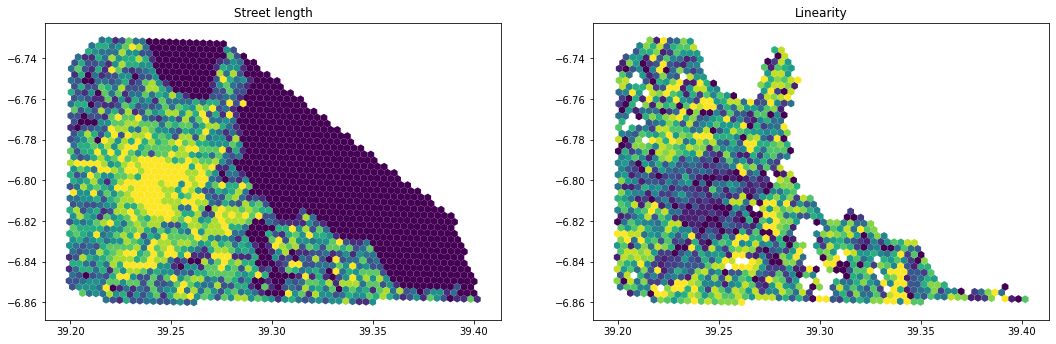

In [22]:
f, axs = plt.subplots(1, 2, figsize=(18, 9))

street_features.plot(column="length",
                     scheme="quantiles",
                     k=12,
                     ax=axs[0]
                    )
axs[0].set_title("Street length")

street_features.plot(column="linearity",
                     scheme="quantiles",
                     k=12,
                     ax=axs[1]
                    )
axs[1].set_title("Linearity");

## Write out

Now we bring everything together into a single table:

In [23]:
db = geopandas.GeoDataFrame({"id": all_polys.index,
                             "geometry": all_polys,
                             "street_length": lengths,
                             "street_linearity": linearities,
                             "building_density": building_count.reindex(all_polys.index)\
                                                               .fillna(0),
                             "building_coverage": building_coverage
                            }, crs=all_polys.crs)
db.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 2046 entries, 897b4c16083ffff to 897b4cbb6dbffff
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   id                 2046 non-null   object  
 1   geometry           2046 non-null   geometry
 2   street_length      2046 non-null   float64 
 3   street_linearity   1304 non-null   float64 
 4   building_density   2046 non-null   float64 
 5   building_coverage  1365 non-null   float64 
dtypes: float64(4), geometry(1), object(1)
memory usage: 111.9+ KB


And write it out into a single file:

In [26]:
! rm -f dar_es_salaam.geojson
db.dropna().to_file("dar_es_salaam.geojson", driver="GeoJSON")